In [5]:
import warnings

warnings.filterwarnings("ignore")

import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# from pandas import DataFrame
import polars as pl
from sklearn.utils import check_random_state
from tqdm import tqdm

plt.style.use("ggplot")

# import open bandit pipeline (obp)
import obp
from obp.dataset import SyntheticBanditDatasetWithActionEmbeds as SyntheticBanditDataset, linear_reward_function
from obp.ope import (
    OffPolicyEvaluation,
    InverseProbabilityWeighting as IPS,
)
from obp.utils import softmax

In [2]:
print(obp.__version__)

0.5.7


## オンライン実験で収集するデータのサイズを変化させたときのAVG推定量の平均二乗誤差の挙動

In [3]:
## シミュレーション設定
num_runs = 500  # シミュレーションの繰り返し回数
dim_context = 10  # 特徴量xの次元
n_actions = 20  # 行動数, |A|
beta = 3  # 方策パラメータ
reward_std = 2  # 報酬のノイズの大きさ
test_data_size = 100000  # 評価方策の真の性能を近似するためのテストデータのサイズ
random_state = 12345
random_ = check_random_state(random_state)
num_data_list = [250, 500, 1000, 2000, 4000, 8000]  # オンライン実験で収集するデータのサイズ

In [12]:
se_df_list = []  # 各シミュレーション設定での推定誤差(二乗誤差)を格納するリスト

for num_data in num_data_list:
    ## 合成データ生成クラス
    dataset = SyntheticBanditDataset(
        n_actions=n_actions,
        dim_context=dim_context,
        action_context=random_.normal(size=(n_actions, 10)),  # 行動の特徴量
        beta=beta,
        reward_type="continuous",
        reward_std=reward_std,
        reward_function=linear_reward_function,
        random_state=random_state,
    )

    ## 評価方策の真の性能(policy value)を近似するためのテストデータを生成
    test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_data_size)

    ## 評価方策の真の性能(policy value)を近似
    value_of_pi = dataset.calc_ground_truth_policy_value(
        expected_reward=test_data["expected_reward"],
        action_dist=softmax(beta * test_data["expected_reward"])[:, :, np.newaxis],
    )

    se_list = []  # 単一のシミュレーション設定での、試行回数分の推定誤差(二乗誤差)を格納するリスト
    for _ in tqdm(range(num_runs), desc=f"num_data: {num_data}..."):
        ## オンライン実験で収集するログデータを、評価方策が形成する同時分布に従い生成
        online_experiment_data = dataset.obtain_batch_bandit_feedback(n_rounds=num_data)

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = softmax(beta * online_experiment_data["expected_reward"])

        ## オンライン実験で収集したログデータを用いて、評価方策の性能(policy value)の推定を実行する
        ope = OffPolicyEvaluation(
            bandit_feedback=online_experiment_data,
            ope_estimators=[IPS(estimator_name="AVG")],  # # IPS推定量は、オンライン実験の設定においてはAVG推定量に一致
        )

        squared_errors = ope.evaluate_performance_of_estimators(
            ground_truth_policy_value=value_of_pi,  # V(\pi)
            action_dist=pi[:, :, np.newaxis],  # \pi(a|x)
            metric="se",  # 推定誤差のmetricとして二乗誤差(se: squared error)を指定
        )
        se_list.append(squared_errors)

    ## シミュレーション結果を集計
    se_df = pl.DataFrame(se_list).select(
        pl.lit(num_data).alias("num_data"),
        pl.col("AVG").alias("se"),  # 推定誤差(二乗誤差)
    )
    se_df_list.append(se_df)

result_df_datasize = pl.concat(se_df_list)
result_df_datasize

num_data: 8000...: 100%|██████████| 500/500 [00:17<00:00, 28.07it/s]


num_data,se
i32,f64
250,0.818912
250,0.224854
250,0.089148
250,0.087331
250,1.074014
…,…
8000,1.359147
8000,1.447675
8000,0.062177


## 報酬のノイズの大きさを変化させたときのAVG推定量の平均二乗誤差の挙動

In [11]:
## 実験設定
num_data = 1000  # オンライン実験で収集するデータのサイズ
noise_list = [0, 2, 4, 6, 8, 10]  # 報酬のノイズの大きさ

In [13]:
se_df_list = []  # 各シミュレーション設定での推定誤差(二乗誤差)を格納するリスト
for noise in noise_list:
    ## 合成データ生成クラス
    dataset = SyntheticBanditDataset(
        n_actions=n_actions,
        dim_context=dim_context,
        action_context=random_.normal(size=(n_actions, 10)),  # 行動の特徴量
        beta=beta,
        reward_type="continuous",
        reward_std=noise,
        reward_function=linear_reward_function,
        random_state=random_state,
    )

    ## 評価方策の真の性能(policy value)を近似するためのテストデータを生成
    test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_data_size)

    ## 評価方策の真の性能(policy value)を近似
    value_of_pi = dataset.calc_ground_truth_policy_value(
        expected_reward=test_data["expected_reward"],
        action_dist=softmax(beta * test_data["expected_reward"])[:, :, np.newaxis],
    )

    se_list = []  # 単一のシミュレーション設定での、試行回数分の推定誤差(二乗誤差)を格納するリスト
    for _ in tqdm(range(num_runs), desc=f"noise: {noise}..."):
        ## オンライン実験で収集するログデータを、評価方策が形成する同時分布に従い生成
        online_experiment_data = dataset.obtain_batch_bandit_feedback(n_rounds=num_data)

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = softmax(beta * online_experiment_data["expected_reward"])

        ## オンライン実験で収集したログデータを用いて、評価方策の性能(policy value)の推定を実行する
        ope = OffPolicyEvaluation(
            bandit_feedback=online_experiment_data,
            ope_estimators=[IPS(estimator_name="AVG")],  # IPS推定量は、オンライン実験の設定においてはAVG推定量に一致
        )

        squared_errors = ope.evaluate_performance_of_estimators(
            ground_truth_policy_value=value_of_pi,  # V(\pi)
            action_dist=pi[:, :, np.newaxis],  # \pi(a|x)
            metric="se",  # 推定誤差のmetricとして二乗誤差(se:  squared error)を指定
        )
        se_list.append(squared_errors)
    ## シミュレーション結果を集計
    se_df = pl.DataFrame(se_list).select(
        pl.lit(noise).alias("reward_std"),
        pl.col("AVG").alias("se"),  # 推定誤差(二乗誤差)
    )
    se_df_list.append(se_df)

result_df_noise = pl.concat(se_df_list)
result_df_noise

noise: 10...: 100%|██████████| 500/500 [00:24<00:00, 20.61it/s]


reward_std,se
i32,f64
0,0.016882
0,0.164626
0,0.266242
0,0.010473
0,0.050015
…,…
10,1.477519
10,1.803513
10,0.018745


## 図1.8

ValueError: Could not interpret value `noise` for parameter `x`

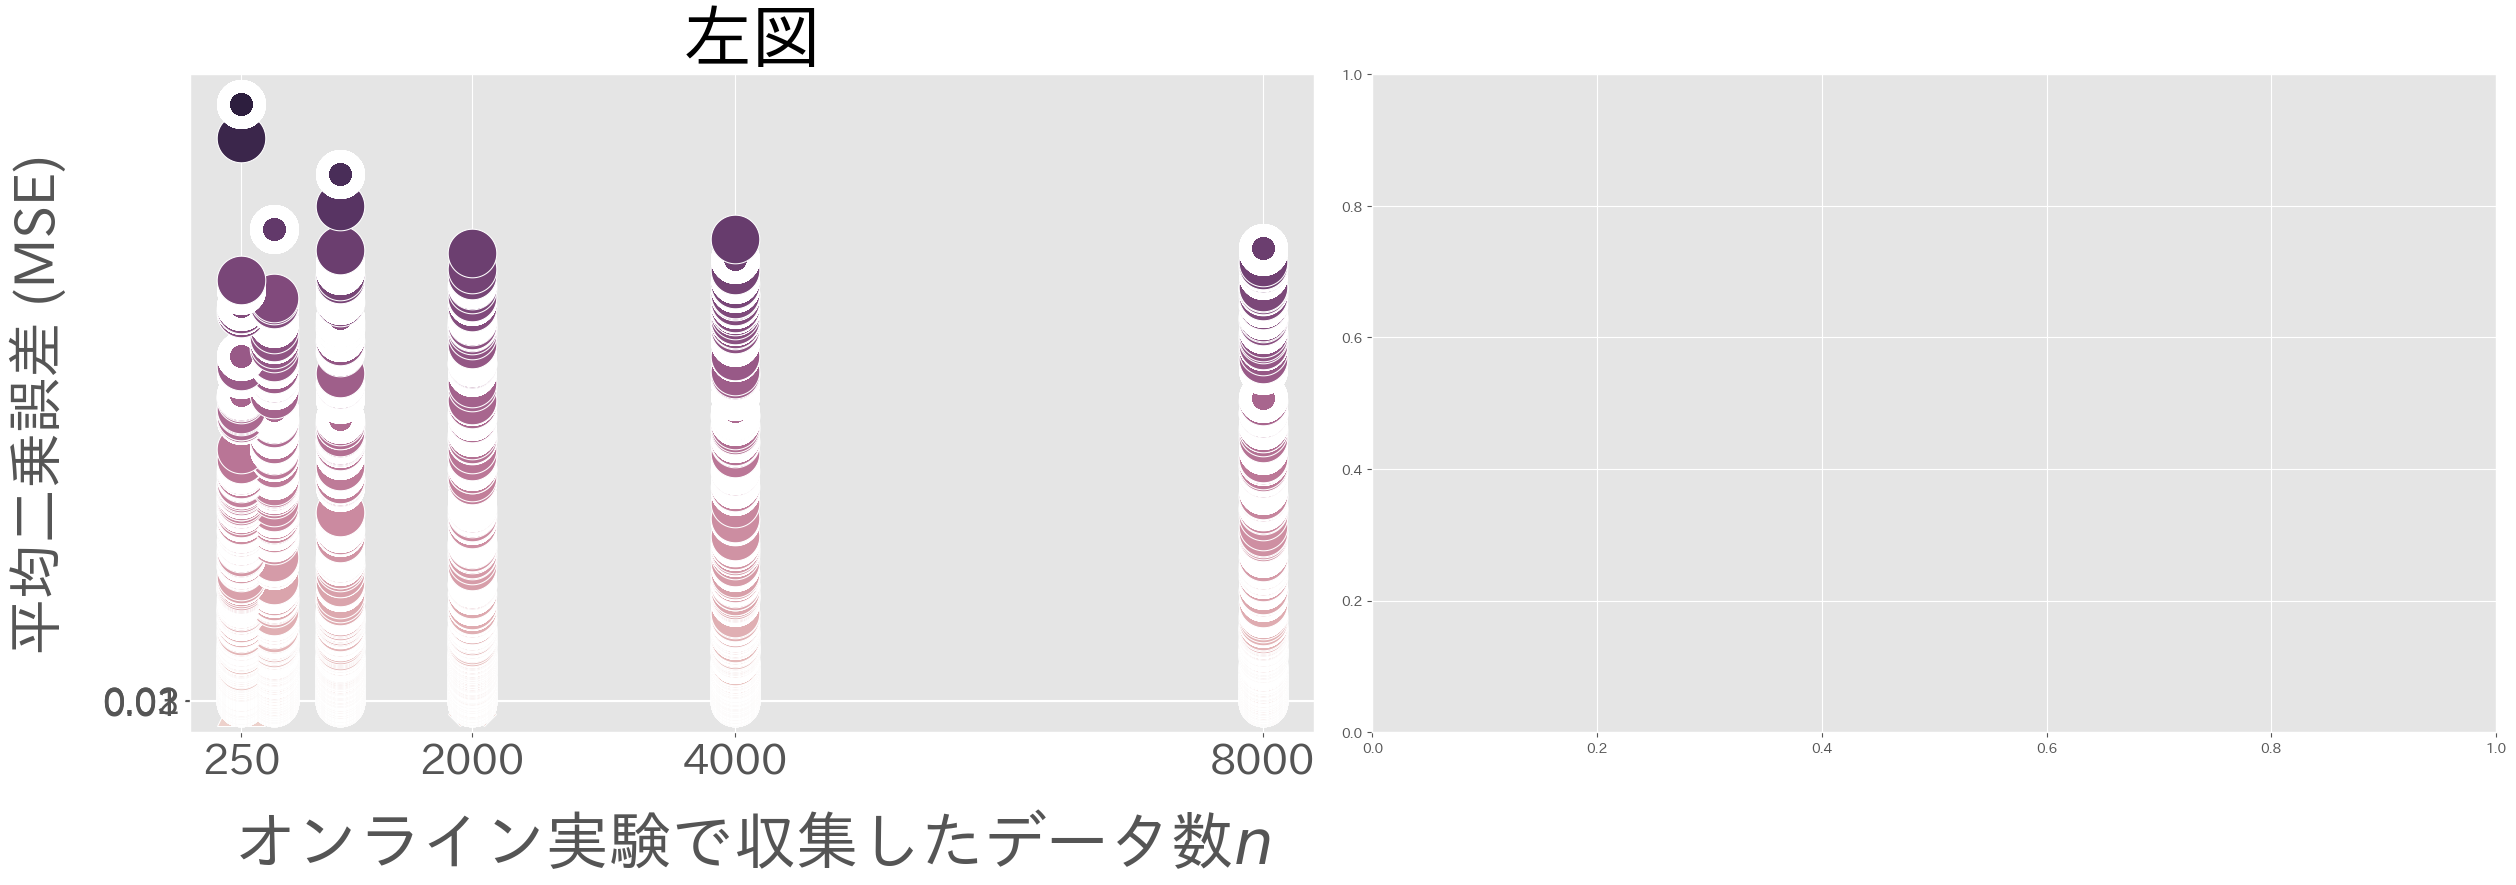

In [15]:
fig, ax_list = plt.subplots(1, 2, figsize=(25, 9), tight_layout=True)
x_dict = {0: "num_data", 1: "noise"}
title_dict = {0: "左図", 1: "右図"}

for i, result_df in enumerate([result_df_datasize, result_df_noise]):
    ax = ax_list[i]

    sns.lineplot(
        markers=True,  # マーカーを表示
        markersize=35,  # マーカーのサイズ
        linewidth=9,
        legend=False,
        style="se",
        x=x_dict[i],
        y="se",
        hue="se",
        ax=ax,
        data=result_df.to_pandas(),
    )

    ax.set_title(title_dict[i], fontsize=50)
    if i == 0:
        ax.set_ylabel("平均二乗誤差 (MSE)", fontsize=40)
        ax.set_yticks([0.01, 0.02, 0.03])
        ax.set_yticklabels([0.01, 0.02, 0.03], fontsize=26)
        ax.yaxis.set_label_coords(-0.11, 0.5)
        ax.set_xlabel(r"オンライン実験で収集したデータ数$n$", fontsize=45)
        ax.set_xticks([250, 2000, 4000, 8000])
        ax.set_xticklabels([250, 2000, 4000, 8000], fontsize=30)
    else:
        ax.set_ylabel("")
        ax.tick_params(axis="y", labelsize=26)
        ax.set_xlabel(r"報酬ノイズの大きさ$\sigma(x,a)$", fontsize=45)
        ax.set_xticks([0, 2, 4, 6, 8, 10])
        ax.set_xticklabels([0, 2, 4, 6, 8, 10], fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)